In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score,roc_curve



#### Import data files

In [25]:
df=pd.read_csv('data/train.csv')
test_df=pd.read_csv('data/test.csv')
data_dict=pd.read_csv('data/data_dictionary.csv')

# ignore warnings
warnings.filterwarnings('ignore')


#### Custom methods

In [342]:
class classificationModel:
    def __init__(self):
        self.train_accuracy=None
        self.train_precision=None
        self.train_recall=None
        self.train_f1_score=None
        self.train_auc_score=None
        self.test_accuracy=None
        self.test_precision=None
        self.test_recall=None
        self.test_f1_score=None
        self.test_auc_score=None
def splitcategories(df):
    nums=df._get_numeric_data().columns
    cats=list(set(df.columns)-set(nums))
    return nums,cats

def filterColsbyNA(df,num):
    df.shape
    temp=pd.DataFrame(df.isna().sum()).reset_index()
    temp=temp.set_axis(['name','nullcount'],axis=1)
    temp['ratio']=temp.nullcount/df.shape[0]*100
    return temp.loc[temp.ratio>num].name.to_list()

def getsmallercols(df,limit):
    nums=df._get_numeric_data().columns.to_list()
    a=[]
    for col in nums:
        if df[col].value_counts().count() < limit:
            a.append(col)
    return a
def addBinnedCols(df,cols,binSize):
    y=list(map(lambda x:x/binSize ,list(range(1,binSize+1)))) 
    for col in cols:
        a=df[col].quantile(y).to_list()
        df[str(col)+'_binned']=df[col].apply(lambda x:getVal(a,x))
    return df
def get_dt_graph(dt_classifier,X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['No Churn', "Churn"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph
def evaluate_model(dt_classifier,X_train,X_test,y_train,y_test):
    cm=classificationModel()
    ##################################################################
    train_predictions=dt_classifier.predict(X_train)
    cm_train=confusion_matrix(y_train, train_predictions)
    TN_train,FP_train,FN_train,TP_train=cm_train.ravel()
    Precision_train=(TP_train) / (TP_train+FP_train)
    Recall_train = (TP_train) / (TP_train+FN_train)
    F1_score_train=2*(Precision_train*Recall_train)/(Precision_train+Recall_train)
    cm.train_accuracy=accuracy_score(y_train,train_predictions)
    cm.train_auc_score=roc_auc_score(y_train,train_predictions)
    cm.train_precision=Precision_train
    cm.train_recall=Recall_train
    cm.train_f1_score=F1_score_train
    ##################################################################
    
    ##################################################################
    test_predictions=dt_classifier.predict(X_test)
    cm_test=confusion_matrix(y_test, test_predictions)
    TN_test,FP_test,FN_test,TP_test=cm_test.ravel()
    Precision_test=(TP_test) / (TP_test+FP_test)
    Recall_test = (TP_test) / (TP_test+FN_test)
    F1_score_test=2*(Precision_test*Recall_test)/(Precision_test+Recall_test)
    cm.test_accuracy=accuracy_score(y_test,test_predictions)
    cm.test_auc_score=roc_auc_score(y_test,test_predictions)
    cm.test_precision=Precision_test
    cm.test_recall=Recall_test
    cm.test_f1_score=F1_score_test
    ##################################################################
    print("="*50+"Training data"+"="*50)
    print("Train Accuracy :%f"%cm.train_accuracy)
    print("Train Confusion Matrix:")
    print(cm_train)
    print("Precision->%f"%cm.train_precision)
    print("Recall->%f"%cm.train_recall)
    print("F1_score->%f"%cm.train_f1_score)
    fpr,tpr,_=roc_curve(y_train,train_predictions)
    plt.plot(fpr,tpr,label="AUC score %f"%cm.train_auc_score)
    plt.legend()
    plt.show()
    print("-"*113)
    print("="*52+"Test data"+"="*52)
    print("Test Accuracy :%f"%cm.test_accuracy )
    print("Test Confusion Matrix:")
    print(cm_test)
    print("Precision->%f"%cm.test_precision)
    print("Recall->%f"%cm.test_recall)
    print("F1_score->%f"%cm.test_f1_score)
    fpr,tpr,_=roc_curve(y_test,test_predictions)
    plt.plot(fpr,tpr,label="AUC score %f"%cm.test_auc_score)
    plt.legend()
    plt.show()
    return cm

In [346]:
global performance_grid
performance_grid={}

#### Data cleaning

In [57]:
nums,cats = splitcategories(df)
print("Total number of categorical variables: %d"%len(cats))
[print('=> '+x) for x in cats]

# Ignoring date of recharge as not adding value to total data set, hence dropping

df.drop(columns=cats,inplace=True)
df.shape

Total number of categorical variables: 0


(69999, 163)

#### Exploratory data analysis

In [58]:
# Checking NA fields

# Visualizing columns with Null values between 1% and 10% of total data set
print("*"*110)
print(list(set(filterColsbyNA(df,1))-set(filterColsbyNA(df,10))))
print("*"*110)
# As most of the values are for mou which represents minutes of usage , we can safely impute by 0 in case of NaN

print("*"*110)
print(filterColsbyNA(df,10))
print("*"*110)

# Even columns with more than 10% of NaN is mostly of recharge 
# so an empty recharge is technically a zero amount recharge

**************************************************************************************************************
['std_og_t2c_mou_7', 'roam_og_mou_7', 'loc_ic_t2f_mou_8', 'loc_og_mou_7', 'std_ic_t2f_mou_8', 'loc_og_t2f_mou_7', 'offnet_mou_8', 'std_og_t2f_mou_8', 'loc_ic_mou_6', 'std_ic_mou_8', 'isd_og_mou_6', 'loc_og_mou_8', 'std_ic_t2o_mou_6', 'roam_ic_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'isd_og_mou_7', 'std_ic_t2t_mou_8', 'loc_ic_t2f_mou_7', 'og_others_6', 'loc_ic_mou_7', 'loc_og_t2t_mou_6', 'roam_og_mou_6', 'loc_og_mou_6', 'loc_ic_mou_8', 'std_ic_t2m_mou_6', 'isd_ic_mou_8', 'loc_ic_t2t_mou_7', 'spl_ic_mou_6', 'loc_og_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_og_t2m_mou_8', 'spl_ic_mou_8', 'spl_og_mou_6', 'std_og_t2o_mou', 'std_og_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_og_t2t_mou_8', 'og_others_8', 'std_og_mou_6', 'spl_og_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2t_mou_7', 'std_ic_t2t_mou_6', 'ic_others_6', 'roam_ic_mou_6', 'spl_og_mou_8', 'onnet_mou_8', 'std_og_t2m_mou_7', 'std_ic_mo

#### Based on NaN analysis above, we would be imputing NaN for whole dataframe

In [59]:
df_imputed=df.fillna(0)


In [60]:
# columns with zero std deviation
temp=df_imputed.describe().transpose().reset_index().rename(columns={'index':'name'})
cols_to_remove=temp.loc[(temp['std']==0)].name.to_list()
cols_to_remove.append('id')




In [61]:
df_imputed.drop(columns=cols_to_remove,inplace=True,errors='ignore')
df_imputed.shape
cols_to_remove


['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'id']

In [62]:
X=df_imputed[set(df_imputed.columns)-set(['churn_probability'])]
y=df_imputed.churn_probability

In [288]:
%%time
plt.figure(figsize=[15,15])
corr=X.corr()
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

CPU times: user 9min 19s, sys: 39.3 s, total: 9min 58s
Wall time: 1min 18s


,feature,VIF
0,total_rech_data_8,inf
1,loc_ic_t2f_mou_8,4.650435e+07
2,std_ic_t2f_mou_8,1.529669e+07
3,fb_user_6,5.919882e+00
4,arpu_2g_6,1.760041e+01
...,...,...
146,loc_ic_t2t_mou_6,6.358087e+08
147,total_rech_amt_8,3.628201e+01
148,std_ic_t2f_mou_6,1.690256e+07
149,std_og_t2f_mou_7,4.654914e+06


<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:>

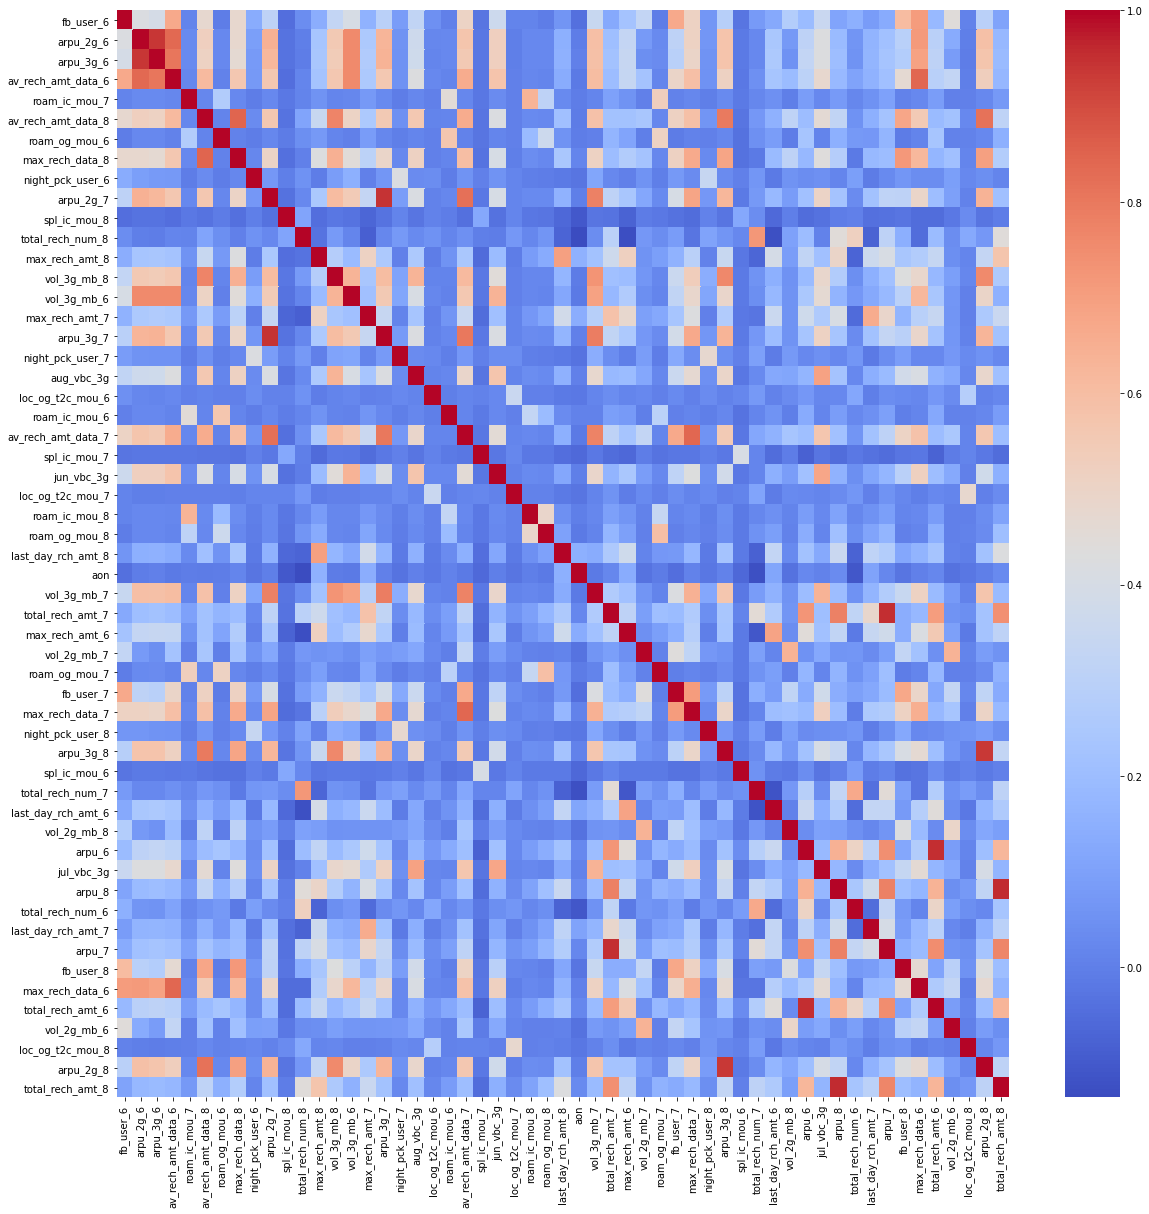

In [212]:
vifs=vif_data.loc[vif_data['VIF']<1000].feature.to_list()
plt.figure(figsize=[20,20])
sns.heatmap(X[vifs].corr(),cmap='coolwarm')

In [293]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=42)

In [294]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [295]:
X_train_scaled.shape

(48999, 151)

## RFE

In [296]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe=RFE(logreg,30)

In [297]:
rfe.fit(X_train_scaled,y_train)
import statsmodels.api as sm

In [298]:
col = X_train.columns[rfe.support_]
X_train_scaled_rfe=X_train_scaled[col]
X_test_scaled_rfe=X_test_scaled[col]

In [299]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3)

dt.fit(X_train_scaled_rfe, y_train)

DecisionTreeClassifier(max_depth=3)

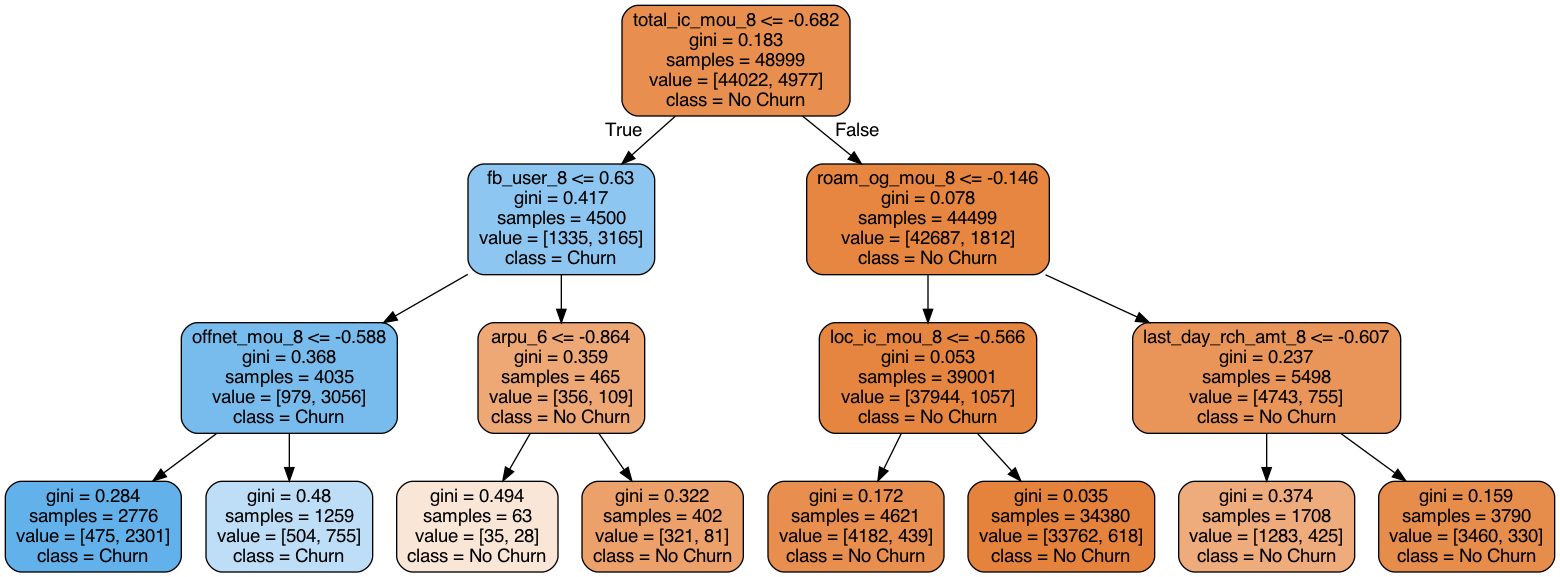

In [300]:
gph=get_dt_graph(dt,X_train_scaled_rfe)
Image(gph.create_png())

In [301]:
y_train_pred = dt.predict(X_train_scaled_rfe)
y_test_pred = dt.predict(X_test_scaled_rfe)

In [302]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print(accuracy_score(y_train, y_train_pred))
cm=confusion_matrix(y_train, y_train_pred)

0.9408151186758913


### Evaluation of model

==================================================Training data==================================================
Train Accuracy :0.940815
Train Confusion Matrix:
[[43043   979]
 [ 1921  3056]]
Precision->0.757373
Recall->0.614025
F1_score->0.678207


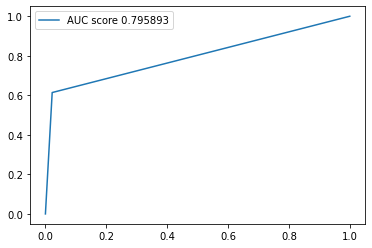

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.941000
Test Confusion Matrix:
[[18423   422]
 [  817  1338]]
Precision->0.760227
Recall->0.620882
F1_score->0.683525


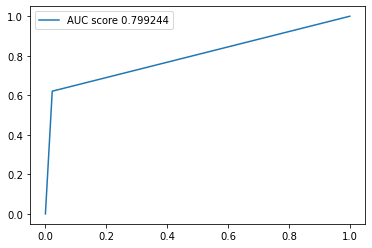

In [355]:
cms=evaluate_model(dt,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Decision_tree']=cms.__dict__

### Random Forest

In [304]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=4, min_samples_leaf=20)
rf.fit(X_train_scaled_rfe, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=20, n_jobs=-1,
                       random_state=42)

In [305]:
sample_tree = rf.estimators_[20]

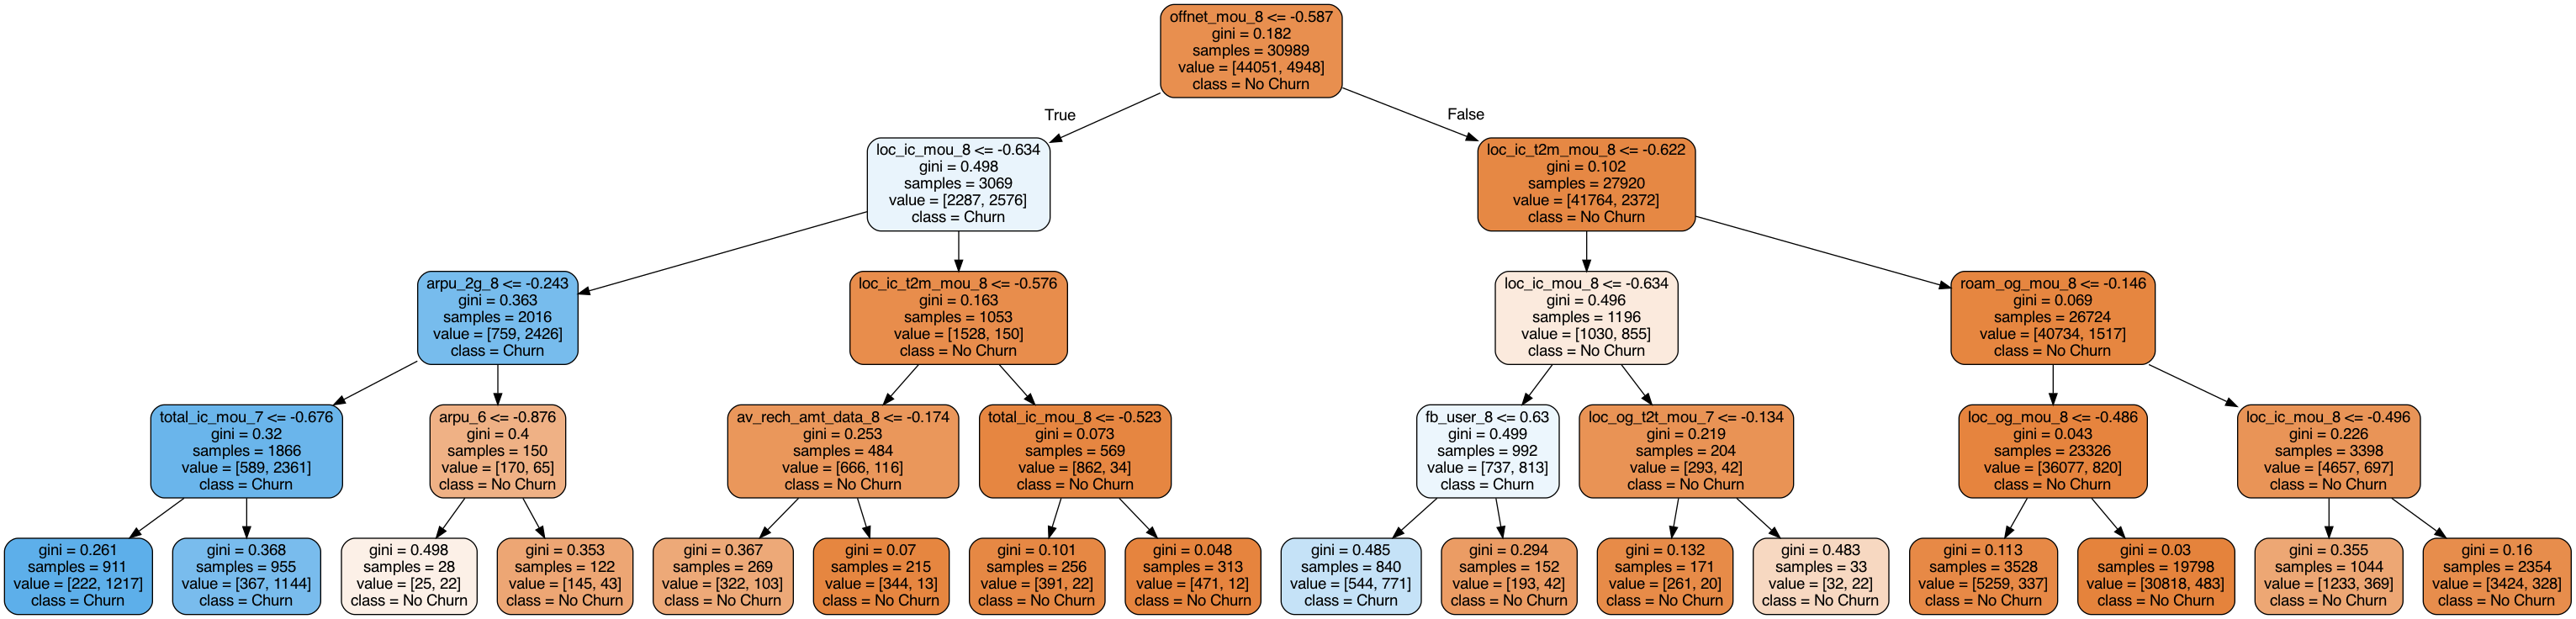

In [306]:
graph=get_dt_graph(sample_tree,X_train_scaled_rfe)
Image(graph.create_png())

In [307]:
y_train_pred = rf.predict(X_train_scaled_rfe)
y_test_pred = rf.predict(X_test_scaled_rfe)

==================================================Training data==================================================
Train Accuracy :0.941366
Train Confusion Matrix:
[[43094   928]
 [ 1945  3032]]
Precision->0.765657
Recall->0.609202
F1_score->0.678527


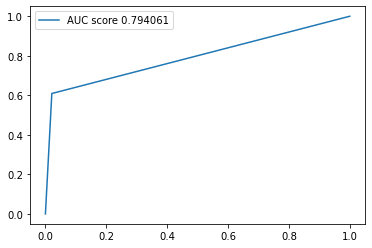

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.941619
Test Confusion Matrix:
[[18442   403]
 [  823  1332]]
Precision->0.767723
Recall->0.618097
F1_score->0.684833


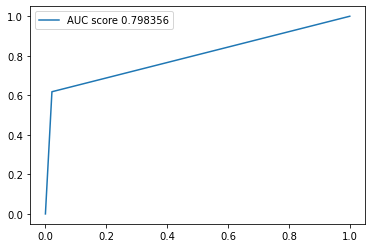

In [356]:
cms=evaluate_model(rf,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Random Forest']=cms.__dict__

#### Grid search for hyper parameter tuning

In [310]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
from sklearn.model_selection import GridSearchCV

In [311]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3],
    'min_samples_leaf': [10, 20],
    'max_features': [3,4,5],
    'n_estimators': [20,50,80]
}

In [312]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")


In [313]:
%%time
grid_search.fit(X_train_scaled_rfe,y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
CPU times: user 3.11 s, sys: 401 ms, total: 3.51 s
Wall time: 20.9 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [10, 20],
                         'n_estimators': [20, 50, 80]},
             scoring='accuracy', verbose=1)

In [314]:
rf_best = grid_search.best_estimator_

In [315]:
rf_best

RandomForestClassifier(max_depth=3, max_features=3, min_samples_leaf=10,
                       n_estimators=80, n_jobs=-1, random_state=42)

==================================================Training data==================================================
Train Accuracy :0.941468
Train Confusion Matrix:
[[43191   831]
 [ 2037  2940]]
Precision->0.779634
Recall->0.590717
F1_score->0.672154


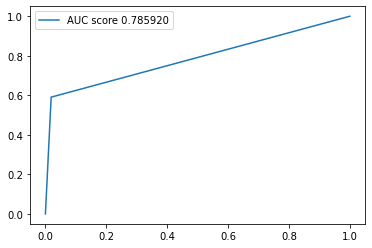

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.942238
Test Confusion Matrix:
[[18492   353]
 [  860  1295]]
Precision->0.785801
Recall->0.600928
F1_score->0.681041


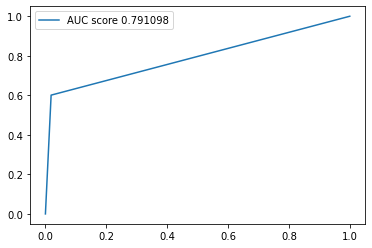

In [357]:
y_train_pred = rf.predict(X_train_scaled_rfe)
y_test_pred = rf.predict(X_test_scaled_rfe)

cms=evaluate_model(rf_best,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['Random Forest CV']=cms.__dict__

In [317]:
sample_tree = rf_best.estimators_[20]

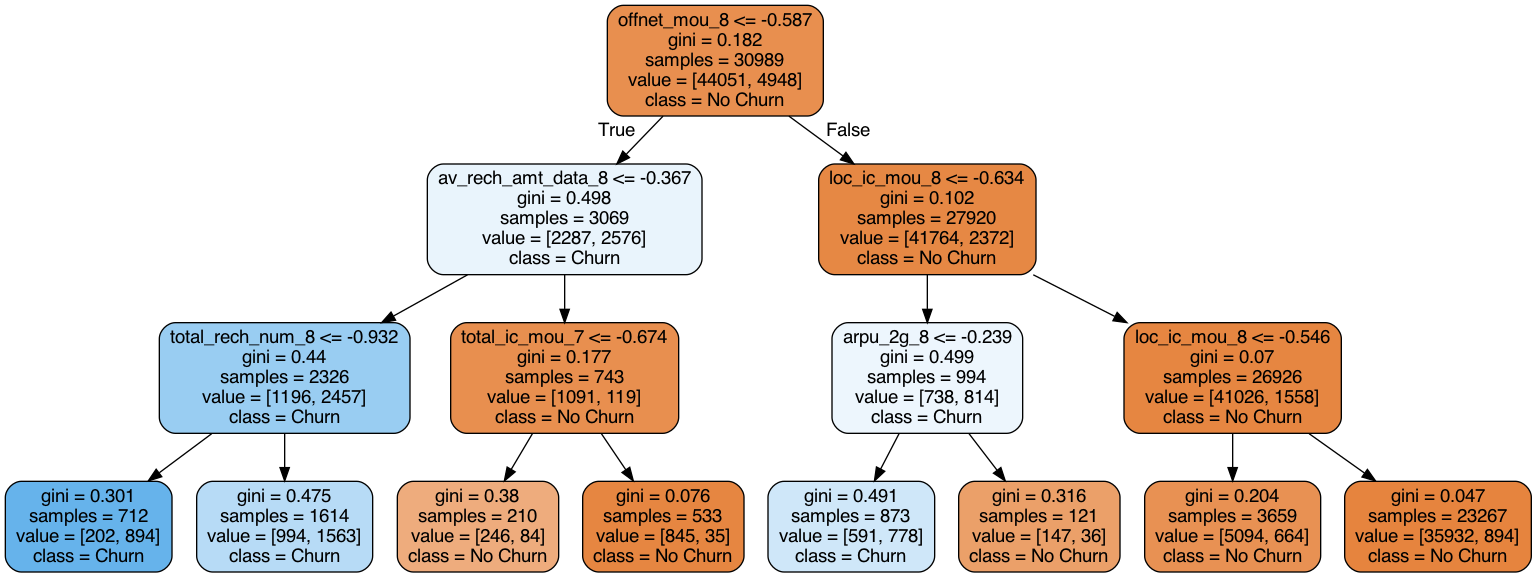

In [318]:
gph = get_dt_graph(sample_tree,X_train_scaled_rfe)
Image(gph.create_png())

### XGBOOST

In [319]:
import xgboost as xgb
#xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',eval_metric='mlogloss')

xgb_cfl = xgb.XGBClassifier(subsample=0.5, n_estimators=20, min_child_weight=3, max_depth=3, learning_rate=0.01, gamma=0.5,colsample_bytree=0.5,eval_metric='mlogloss')





In [320]:
xgb_cfl.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'enable_categorical': False,
 'gamma': 0.5,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_delta_step': None,
 'max_depth': 3,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 20,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'mlogloss'}

In [321]:
# Fit the model to our train and target
xgb_cfl.fit(X_train_scaled_rfe, y_train)  # default 
# Get our predictions
xgb_predictions = xgb_cfl.predict(X_test_scaled_rfe)
xgb_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [322]:
xgb_predictions_prob = xgb_cfl.predict_proba(X_test_scaled_rfe)
xgb_predictions_prob

array([[0.58684766, 0.4131523 ],
       [0.5850086 , 0.4149914 ],
       [0.58369446, 0.41630557],
       ...,
       [0.5809883 , 0.4190117 ],
       [0.5878501 , 0.41214994],
       [0.5878501 , 0.41214994]], dtype=float32)

In [323]:
accuracy_score(y_test, xgb_predictions)

0.9409047619047619

In [324]:
confusion_matrix(y_test, xgb_predictions)

array([[18423,   422],
       [  819,  1336]])

==================================================Training data==================================================
Train Accuracy :0.940815
Train Confusion Matrix:
[[43053   969]
 [ 1931  3046]]
Precision->0.758655
Recall->0.612015
F1_score->0.677491


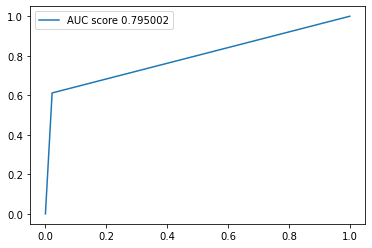

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.940905
Test Confusion Matrix:
[[18423   422]
 [  819  1336]]
Precision->0.759954
Recall->0.619954
F1_score->0.682852


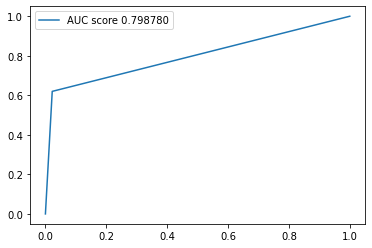

In [358]:
cms=evaluate_model(xgb_cfl,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['XG Boost']=cms.__dict__

In [326]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
# A parameter grid for XGBoost
# params = {
#         'n_estimators' : [100, 200, 500, 750], # no of trees 
#         'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
#         'min_child_weight': [1, 5, 7, 10],
#         'gamma': [0.1, 0.5, 1, 1.5, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5, 10, 12]
#         }

params = {
        'n_estimators' : [20,50], # no of trees 
        'learning_rate' : [0.02,0.05],  # eta
        'min_child_weight': [5],
        'gamma': [0.5,0.75],
        'subsample': [0.6,0.8],
        'colsample_bytree': [0.6],
        'max_depth': [3, 5]
        }
folds = 5

param_comb = 800
random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3, random_state=42)



In [327]:
%%time
random_search.fit(X_train_scaled_rfe,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 15.4 s, sys: 512 ms, total: 15.9 s
Wall time: 53.2 s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.5,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=0.5,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.01, max_delta_step=0,
                                           max_depth=3, min_child_weight=3,
                                           missing=nan,
                                           monotone_constr...
                                           reg_alpha=0, reg_lambda=1,
                                           scale_pos_weight=1, subs

In [328]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.75,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

 Best accuracy for 5-fold search with 800 parameter combinations:
0.9315184609472686

 Best hyperparameters:
{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.75, 'colsample_bytree': 0.6}


==================================================Training data==================================================
Train Accuracy :0.942591
Train Confusion Matrix:
[[43113   909]
 [ 1904  3073]]
Precision->0.771723
Recall->0.617440
F1_score->0.686014


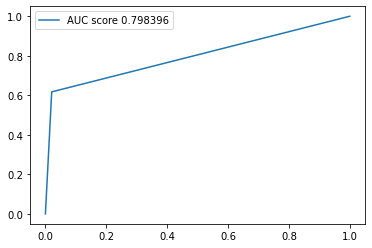

-----------------------------------------------------------------------------------------------------------------
====================================================Test data====================================================
Test Accuracy :0.941381
Test Confusion Matrix:
[[18435   410]
 [  821  1334]]
Precision->0.764908
Recall->0.619026
F1_score->0.684278


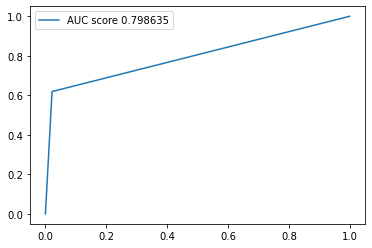

In [359]:
cms=evaluate_model(random_search,X_train_scaled_rfe,X_test_scaled_rfe,y_train,y_test)
performance_grid['XG Bosst Random_search']=cms.__dict__

In [330]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [369]:
pg=pd.DataFrame(performance_grid).transpose()